In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

In [2]:
def get_npy_file_paths(directory):
    return sorted(glob.glob(os.path.join(directory, "*.npy")))

# load file paths 
lr_dir = "/kaggle/input/dataset-3b/Dataset/LR"  
hr_dir = "/kaggle/input/dataset-3b/Dataset/HR"
lr_path =  get_npy_file_paths(lr_dir)
hr_path = get_npy_file_paths(hr_dir)


In [3]:
lr_path_tr,lr_path_test = train_test_split(lr_path,train_size=0.9, shuffle=True,random_state=42)
hr_path_tr,hr_path_test = train_test_split(hr_path,train_size=0.9, shuffle=True,random_state=42)

In [4]:
# custom dataset class
class SRDataset(Dataset):
    def __init__(self, lr_path, hr_path, transform=None):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.transform = transform

    def __len__(self):
        return len(self.lr_path)

    def __getitem__(self, idx):
        lr = np.load(self.lr_path[idx]).astype(np.float32)  # Low-resolution image
        hr = np.load(self.hr_path[idx]).astype(np.float32)  # High-resolution image

        if self.transform:
            lr = self.transform(torch.tensor(lr, dtype=torch.float32))  
            hr = self.transform(torch.tensor(hr, dtype=torch.float32))
        return lr, hr

# Define transforms for normalization (-1 to 1 range)
transform = transforms.Compose([
    # transforms.Normalize(mean=[lr_mean], std=[lr_std])
])


In [5]:
# Loading  dataset

dataset_train = SRDataset(lr_path_tr, hr_path_tr, transform=transform)
dataset_test = SRDataset(lr_path_test,hr_path_test,transform=transform)
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test,batch_size=16,shuffle=True)

In [6]:
# RCAN Model
# Channel Attention (CA) Block
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

# Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(self, channel):
        super(RCAB, self).__init__()
        self.conv1 = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
        self.ca = CALayer(channel)
    
    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        res = self.ca(res)
        return res + x  # Residual connection

# Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, channel, num_rcab):
        super(ResidualGroup, self).__init__()
        self.rcabs = nn.Sequential(*[RCAB(channel) for _ in range(num_rcab)])
        self.conv = nn.Conv2d(channel, channel, 3, padding=1, bias=True)
    
    def forward(self, x):
        res = self.rcabs(x)
        res = self.conv(res)
        return res + x

# RCAN Model
class RCAN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_features=64, num_rg=2, num_rcab=4):
        super(RCAN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)
        
        self.residual_groups = nn.Sequential(*[ResidualGroup(num_features, num_rcab) for _ in range(num_rg)])
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        
        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.residual_groups(x1)
        x3 = self.conv2(x2) + x1  # Global residual connection
        out = self.upsample(x3)
        return torch.clamp(out, 0, 1)


In [7]:
# Load pretrained model
checkpoint = '/kaggle/input/rcan-pretrained/RCAN_weights (1).pth'
rcan = RCAN().to(device)
rcan.load_state_dict(torch.load(checkpoint,map_location=device))

<ipython-input-7-79140502f1a1>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rcan.load_state_dict(torch.load(checkpoint,map_location=device))


<All keys matched successfully>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define loss function
criterion_pixel = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(rcan.parameters(), lr=1e-4)
num_epochs = 100
# Define scheduler (Choose one)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=5e-7)

for epoch in range(num_epochs):
    # Training Phase
    rcan.train()
    train_loss = 0.0
    for lr, hr in tqdm(train_dataloader):
        lr, hr = lr.to(device), hr.to(device)

        # Forward pass
        fake_hr = rcan(lr)
        
        # Compute loss
        loss = criterion_pixel(fake_hr, hr)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation Phase
    rcan.eval()
    test_loss = 0.0
    with torch.no_grad():
        for lr, hr in test_dataloader:
            lr, hr = lr.to(device), hr.to(device)
            fake_hr = rcan(lr)
            loss = criterion_pixel(fake_hr, hr)
            test_loss += loss.item()

    test_loss /= len(test_dataloader)

    # Update scheduler
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Curr Learning rate : {current_lr:.7f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataloader):.6f}, Test Loss: {test_loss:.6f}")


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


Curr Learning rate : 0.0001000
Epoch 1/100, Train Loss: 0.003045, Test Loss: 0.002148


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


Curr Learning rate : 0.0000999
Epoch 2/100, Train Loss: 0.002359, Test Loss: 0.001512


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


Curr Learning rate : 0.0000998
Epoch 3/100, Train Loss: 0.001955, Test Loss: 0.001048


100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Curr Learning rate : 0.0000996
Epoch 4/100, Train Loss: 0.001812, Test Loss: 0.001043


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


Curr Learning rate : 0.0000994
Epoch 5/100, Train Loss: 0.001601, Test Loss: 0.001148


100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


Curr Learning rate : 0.0000991
Epoch 6/100, Train Loss: 0.001547, Test Loss: 0.000952


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Curr Learning rate : 0.0000988
Epoch 7/100, Train Loss: 0.001883, Test Loss: 0.000892


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


Curr Learning rate : 0.0000984
Epoch 8/100, Train Loss: 0.001397, Test Loss: 0.000886


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


Curr Learning rate : 0.0000980
Epoch 9/100, Train Loss: 0.001538, Test Loss: 0.001091


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


Curr Learning rate : 0.0000976
Epoch 10/100, Train Loss: 0.001494, Test Loss: 0.000967


100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


Curr Learning rate : 0.0000971
Epoch 11/100, Train Loss: 0.001351, Test Loss: 0.000829


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


Curr Learning rate : 0.0000965
Epoch 12/100, Train Loss: 0.001333, Test Loss: 0.000862


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


Curr Learning rate : 0.0000959
Epoch 13/100, Train Loss: 0.001388, Test Loss: 0.000898


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Curr Learning rate : 0.0000953
Epoch 14/100, Train Loss: 0.001348, Test Loss: 0.000808


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Curr Learning rate : 0.0000946
Epoch 15/100, Train Loss: 0.001309, Test Loss: 0.000819


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Curr Learning rate : 0.0000938
Epoch 16/100, Train Loss: 0.001678, Test Loss: 0.000878


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


Curr Learning rate : 0.0000931
Epoch 17/100, Train Loss: 0.001235, Test Loss: 0.000919


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


Curr Learning rate : 0.0000923
Epoch 18/100, Train Loss: 0.001242, Test Loss: 0.000770


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Curr Learning rate : 0.0000914
Epoch 19/100, Train Loss: 0.001175, Test Loss: 0.000791


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Curr Learning rate : 0.0000905
Epoch 20/100, Train Loss: 0.001192, Test Loss: 0.000846


100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


Curr Learning rate : 0.0000896
Epoch 21/100, Train Loss: 0.001151, Test Loss: 0.000897


100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


Curr Learning rate : 0.0000886
Epoch 22/100, Train Loss: 0.001191, Test Loss: 0.000771


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


Curr Learning rate : 0.0000876
Epoch 23/100, Train Loss: 0.001196, Test Loss: 0.000796


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


Curr Learning rate : 0.0000865
Epoch 24/100, Train Loss: 0.001155, Test Loss: 0.000809


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


Curr Learning rate : 0.0000854
Epoch 25/100, Train Loss: 0.001163, Test Loss: 0.000761


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Curr Learning rate : 0.0000843
Epoch 26/100, Train Loss: 0.001187, Test Loss: 0.000838


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Curr Learning rate : 0.0000832
Epoch 27/100, Train Loss: 0.001141, Test Loss: 0.000877


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Curr Learning rate : 0.0000820
Epoch 28/100, Train Loss: 0.001155, Test Loss: 0.000836


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Curr Learning rate : 0.0000807
Epoch 29/100, Train Loss: 0.001156, Test Loss: 0.000826


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Curr Learning rate : 0.0000795
Epoch 30/100, Train Loss: 0.001140, Test Loss: 0.000812


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


Curr Learning rate : 0.0000782
Epoch 31/100, Train Loss: 0.001128, Test Loss: 0.000855


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


Curr Learning rate : 0.0000769
Epoch 32/100, Train Loss: 0.001125, Test Loss: 0.000799


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


Curr Learning rate : 0.0000756
Epoch 33/100, Train Loss: 0.001581, Test Loss: 0.000839


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


Curr Learning rate : 0.0000742
Epoch 34/100, Train Loss: 0.001266, Test Loss: 0.000774


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


Curr Learning rate : 0.0000728
Epoch 35/100, Train Loss: 0.001183, Test Loss: 0.000792


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Curr Learning rate : 0.0000714
Epoch 36/100, Train Loss: 0.001086, Test Loss: 0.000755


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Curr Learning rate : 0.0000700
Epoch 37/100, Train Loss: 0.001074, Test Loss: 0.000747


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Curr Learning rate : 0.0000686
Epoch 38/100, Train Loss: 0.001095, Test Loss: 0.000762


100%|██████████| 9/9 [00:01<00:00,  5.26it/s]


Curr Learning rate : 0.0000671
Epoch 39/100, Train Loss: 0.001086, Test Loss: 0.000763


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


Curr Learning rate : 0.0000656
Epoch 40/100, Train Loss: 0.001073, Test Loss: 0.000777


100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


Curr Learning rate : 0.0000641
Epoch 41/100, Train Loss: 0.001060, Test Loss: 0.000742


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


Curr Learning rate : 0.0000626
Epoch 42/100, Train Loss: 0.001074, Test Loss: 0.000764


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


Curr Learning rate : 0.0000611
Epoch 43/100, Train Loss: 0.001162, Test Loss: 0.000787


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


Curr Learning rate : 0.0000596
Epoch 44/100, Train Loss: 0.001065, Test Loss: 0.000775


100%|██████████| 9/9 [00:01<00:00,  5.45it/s]


Curr Learning rate : 0.0000580
Epoch 45/100, Train Loss: 0.001101, Test Loss: 0.000758


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


Curr Learning rate : 0.0000565
Epoch 46/100, Train Loss: 0.001109, Test Loss: 0.000799


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


Curr Learning rate : 0.0000549
Epoch 47/100, Train Loss: 0.001111, Test Loss: 0.000810


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


Curr Learning rate : 0.0000534
Epoch 48/100, Train Loss: 0.001099, Test Loss: 0.000750


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


Curr Learning rate : 0.0000518
Epoch 49/100, Train Loss: 0.001095, Test Loss: 0.000741


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


Curr Learning rate : 0.0000502
Epoch 50/100, Train Loss: 0.001083, Test Loss: 0.000796


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


Curr Learning rate : 0.0000487
Epoch 51/100, Train Loss: 0.001060, Test Loss: 0.000744


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


Curr Learning rate : 0.0000471
Epoch 52/100, Train Loss: 0.001520, Test Loss: 0.000768


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


Curr Learning rate : 0.0000456
Epoch 53/100, Train Loss: 0.001116, Test Loss: 0.000787


100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


Curr Learning rate : 0.0000440
Epoch 54/100, Train Loss: 0.001581, Test Loss: 0.000753


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


Curr Learning rate : 0.0000425
Epoch 55/100, Train Loss: 0.001097, Test Loss: 0.000802


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Curr Learning rate : 0.0000409
Epoch 56/100, Train Loss: 0.001083, Test Loss: 0.000719


100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Curr Learning rate : 0.0000394
Epoch 57/100, Train Loss: 0.001098, Test Loss: 0.000801


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Curr Learning rate : 0.0000379
Epoch 58/100, Train Loss: 0.001480, Test Loss: 0.000728


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Curr Learning rate : 0.0000364
Epoch 59/100, Train Loss: 0.001073, Test Loss: 0.000743


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


Curr Learning rate : 0.0000349
Epoch 60/100, Train Loss: 0.001119, Test Loss: 0.000764


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Curr Learning rate : 0.0000334
Epoch 61/100, Train Loss: 0.001072, Test Loss: 0.000783


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Curr Learning rate : 0.0000319
Epoch 62/100, Train Loss: 0.001100, Test Loss: 0.000783


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Curr Learning rate : 0.0000305
Epoch 63/100, Train Loss: 0.001102, Test Loss: 0.000755


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


Curr Learning rate : 0.0000291
Epoch 64/100, Train Loss: 0.001068, Test Loss: 0.000756


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Curr Learning rate : 0.0000277
Epoch 65/100, Train Loss: 0.001097, Test Loss: 0.000744


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Curr Learning rate : 0.0000263
Epoch 66/100, Train Loss: 0.001112, Test Loss: 0.000741


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Curr Learning rate : 0.0000249
Epoch 67/100, Train Loss: 0.001074, Test Loss: 0.000724


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Curr Learning rate : 0.0000236
Epoch 68/100, Train Loss: 0.001101, Test Loss: 0.000779


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


Curr Learning rate : 0.0000223
Epoch 69/100, Train Loss: 0.001046, Test Loss: 0.000769


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


Curr Learning rate : 0.0000210
Epoch 70/100, Train Loss: 0.001040, Test Loss: 0.000742


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


Curr Learning rate : 0.0000198
Epoch 71/100, Train Loss: 0.001069, Test Loss: 0.000715


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


Curr Learning rate : 0.0000185
Epoch 72/100, Train Loss: 0.001050, Test Loss: 0.000748


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


Curr Learning rate : 0.0000173
Epoch 73/100, Train Loss: 0.001050, Test Loss: 0.000751


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Curr Learning rate : 0.0000162
Epoch 74/100, Train Loss: 0.001132, Test Loss: 0.000771


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


Curr Learning rate : 0.0000151
Epoch 75/100, Train Loss: 0.001046, Test Loss: 0.000730


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


Curr Learning rate : 0.0000140
Epoch 76/100, Train Loss: 0.001056, Test Loss: 0.000726


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Curr Learning rate : 0.0000129
Epoch 77/100, Train Loss: 0.001043, Test Loss: 0.000746


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


Curr Learning rate : 0.0000119
Epoch 78/100, Train Loss: 0.001114, Test Loss: 0.000769


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


Curr Learning rate : 0.0000109
Epoch 79/100, Train Loss: 0.001051, Test Loss: 0.000753


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Curr Learning rate : 0.0000100
Epoch 80/100, Train Loss: 0.001038, Test Loss: 0.000785


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Curr Learning rate : 0.0000091
Epoch 81/100, Train Loss: 0.001049, Test Loss: 0.000727


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


Curr Learning rate : 0.0000082
Epoch 82/100, Train Loss: 0.001058, Test Loss: 0.000722


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


Curr Learning rate : 0.0000074
Epoch 83/100, Train Loss: 0.001050, Test Loss: 0.000782


100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


Curr Learning rate : 0.0000067
Epoch 84/100, Train Loss: 0.001054, Test Loss: 0.000723


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


Curr Learning rate : 0.0000059
Epoch 85/100, Train Loss: 0.001087, Test Loss: 0.000746


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


Curr Learning rate : 0.0000052
Epoch 86/100, Train Loss: 0.001049, Test Loss: 0.000747


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


Curr Learning rate : 0.0000046
Epoch 87/100, Train Loss: 0.001058, Test Loss: 0.000712


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


Curr Learning rate : 0.0000040
Epoch 88/100, Train Loss: 0.001058, Test Loss: 0.000724


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


Curr Learning rate : 0.0000034
Epoch 89/100, Train Loss: 0.001080, Test Loss: 0.000751


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


Curr Learning rate : 0.0000029
Epoch 90/100, Train Loss: 0.001049, Test Loss: 0.000755


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


Curr Learning rate : 0.0000025
Epoch 91/100, Train Loss: 0.001081, Test Loss: 0.000740


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Curr Learning rate : 0.0000021
Epoch 92/100, Train Loss: 0.001042, Test Loss: 0.000774


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


Curr Learning rate : 0.0000017
Epoch 93/100, Train Loss: 0.001033, Test Loss: 0.000750


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


Curr Learning rate : 0.0000014
Epoch 94/100, Train Loss: 0.001045, Test Loss: 0.000735


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Curr Learning rate : 0.0000011
Epoch 95/100, Train Loss: 0.001068, Test Loss: 0.000731


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


Curr Learning rate : 0.0000009
Epoch 96/100, Train Loss: 0.001049, Test Loss: 0.000739


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


Curr Learning rate : 0.0000007
Epoch 97/100, Train Loss: 0.001031, Test Loss: 0.000742


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


Curr Learning rate : 0.0000006
Epoch 98/100, Train Loss: 0.001082, Test Loss: 0.000718


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


Curr Learning rate : 0.0000005
Epoch 99/100, Train Loss: 0.001045, Test Loss: 0.000721


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]

Curr Learning rate : 0.0000005
Epoch 100/100, Train Loss: 0.001039, Test Loss: 0.000718


In [9]:
# save weights
# save model
rcan.eval()
checkpoint = '/kaggle/working/RCAN_weights_finetuned.pth'
torch.save(rcan.state_dict(),checkpoint)

In [10]:
#  code for evaluating metric
# MSE loss
def mse(hr, sr):
    return np.mean((hr - sr) ** 2)
# PSNR 
def psnr(hr, sr):
    mse_value = mse(hr, sr)
    if mse_value == 0:
        return float('inf')  # No difference between images
    max_pixel = 1.0  # Assuming 8-bit images
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))
# SSIM
def calculate_ssim(hr, sr):
    return ssim(hr, sr, data_range=hr.max() - hr.min())


In [11]:
def eval_metric(model,dataset):
    model.eval()
    model.to(device)

    avg_mse = 0.0
    avg_psnr = 0.0
    avg_ssim = 0.0

    for idx in tqdm(range(len(dataset))):
        hr_img = dataset[idx][1].to(device).squeeze()  # Move HR image to device
        lr_img = dataset[idx][0].unsqueeze(0).to(device)  # Move LR image to device

        with torch.no_grad():
            fake_hr_img = model(lr_img).squeeze().cpu().numpy()  # Move output to CPU for numpy

        avg_mse += mse(hr_img.cpu().numpy(), fake_hr_img)
        avg_psnr += psnr(hr_img.cpu().numpy(), fake_hr_img)
        avg_ssim += calculate_ssim(hr_img.cpu().numpy(), fake_hr_img)

    print(f'Average MSE Loss : {avg_mse / len(dataset):.4f}')
    print(f'Average PSNR : {avg_psnr / len(dataset):.4f}')
    print(f'Average SSIM : {avg_ssim / len(dataset):.4f}')
eval_metric(rcan,dataset_test)

100%|██████████| 30/30 [00:00<00:00, 79.32it/s]

Average MSE Loss : 0.0007
Average PSNR : 35.8791
Average SSIM : 0.8611


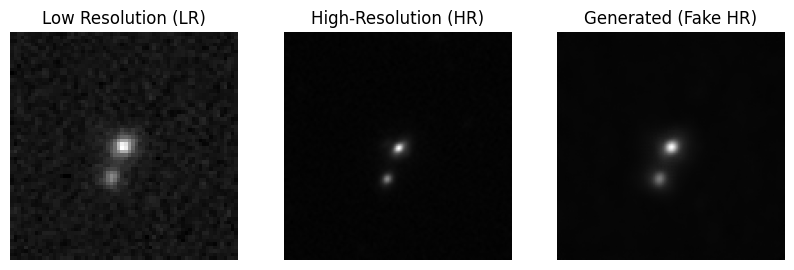

MSE Loss : 0.0002661781036294997 || PSNR : 35.748277208717035 || SSIM : 0.9190711461225847


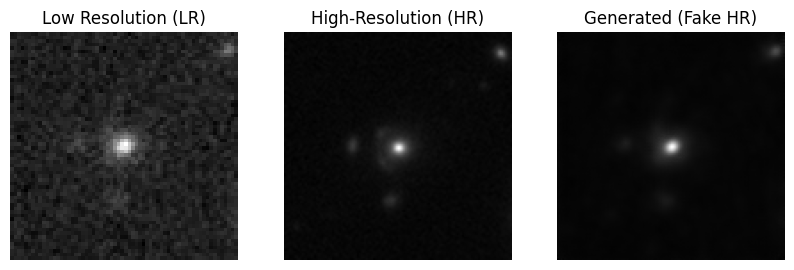

MSE Loss : 0.00019433541456237435 || PSNR : 37.11448050823709 || SSIM : 0.9258593734723206


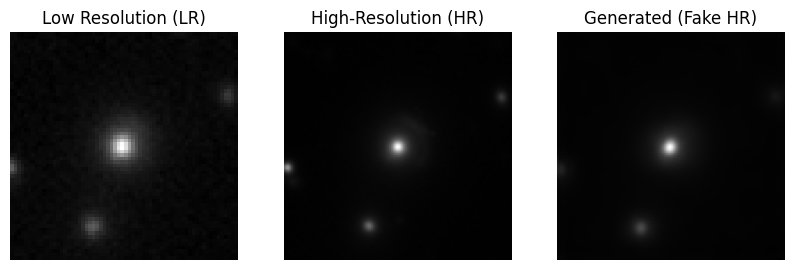

MSE Loss : 0.00021872746583539993 || PSNR : 36.600966651717584 || SSIM : 0.9617919778670075


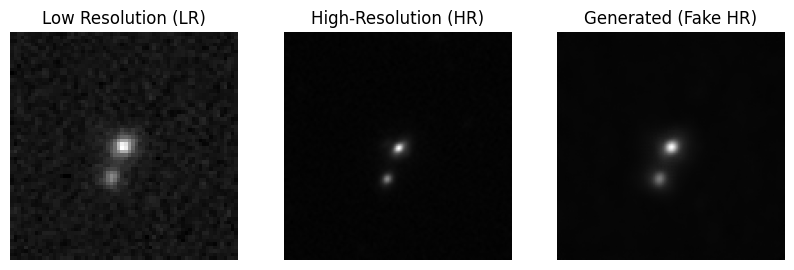

MSE Loss : 0.0002661781036294997 || PSNR : 35.748277208717035 || SSIM : 0.9190711461225847


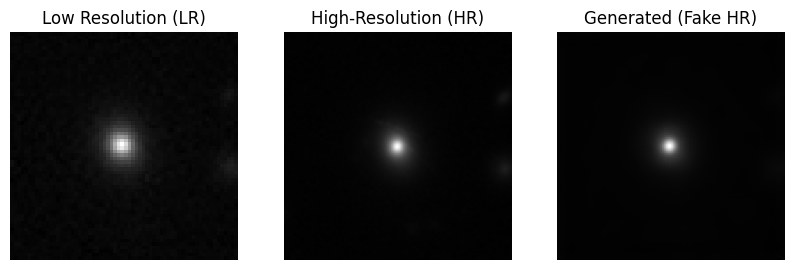

MSE Loss : 0.00020848825806751847 || PSNR : 36.80918383036751 || SSIM : 0.9748008279022239


In [12]:
def visualize(model,idx,dataset_test):
    model.to(device)
    hr_img = dataset_test[idx][1].to(device).squeeze()  # Move HR image to device
    lr_img = dataset_test[idx][0].unsqueeze(0).to(device)  # Move LR image to device

    with torch.no_grad():
        fake_hr_img = model(lr_img).squeeze().cpu().numpy()  # Move output to CPU for numpy
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # plot LR Image
    axes[0].imshow(lr_img.squeeze().cpu().numpy(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[0].set_title("Low Resolution (LR)")
    axes[0].axis("off")
    
    # Plot HR image
    axes[1].imshow(hr_img.squeeze().cpu().numpy(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[1].set_title("High-Resolution (HR)")
    axes[1].axis("off")
    
    # Plot Fake HR image
    axes[2].imshow(fake_hr_img.squeeze(), cmap='gray')
    axes[2].set_title("Generated (Fake HR)")
    axes[2].axis("off")
    
    # Show the images
    plt.show()
    print(f'MSE Loss : {mse(hr_img.cpu().numpy(),fake_hr_img)}',end=' || ')
    print(f'PSNR : {psnr(hr_img.cpu().numpy(),fake_hr_img)}',end=' || ')
    print(f'SSIM : {calculate_ssim(hr_img.cpu().numpy(),fake_hr_img)}')


samples = np.random.randint(0,len(dataset_test)-1,5)
for idx in samples:
    visualize(rcan,idx,dataset_test)